<a href="https://colab.research.google.com/github/Heoyuna0819/machine_learning/blob/main/UCI_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix='/content/drive/MyDrive/UCI HAR Dataset/'):
    trainX, trainy = load_dataset_group('train', prefix)
    testX, testy = load_dataset_group('test', prefix)
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1558901940.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [3]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [4]:
from sklearn.preprocessing import StandardScaler

X_train_r = X_train.reshape(-1, n_features)
X_val_r = X_val.reshape(-1, n_features)
testX_r = testX.reshape(-1, n_features)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_r)
X_val_s = scaler.transform(X_val_r)
testX_s = scaler.transform(testX_r)

X_train = X_train_s.reshape(-1, n_timesteps, n_features)
X_val = X_val_s.reshape(-1, n_timesteps, n_features)
testX = testX_s.reshape(-1, n_timesteps, n_features)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

model = Sequential([

LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)),
Dropout(0.2),

LSTM(64),
Dropout(0.2),

BatchNormalization(),
Dense(128, activation='relu'),
Dropout(0.3),
Dense(n_outputs, activation='softmax')

])

optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train_one_hot,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[es, lr_scheduler],
    verbose=1
)


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.6714 - loss: 0.8616 - val_accuracy: 0.9300 - val_loss: 0.3308 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.9288 - loss: 0.1976 - val_accuracy: 0.9279 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 385ms/step - accuracy: 0.9422 - loss: 0.1609 - val_accuracy: 0.9375 - val_loss: 0.1541 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.9493 - loss: 0.1272 - val_accuracy: 0.9497 - val_loss: 0.1227 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.9477 - loss: 0.1273 - val_accuracy: 0.9456 - val_loss: 0.1327 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 378ms/step - accuracy: 0.9545 - loss: 0.1309 - val_accuracy: 0.9415 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9501 - loss: 0.1

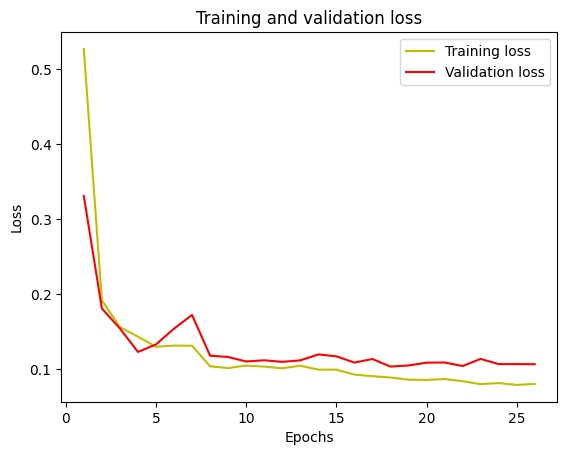

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

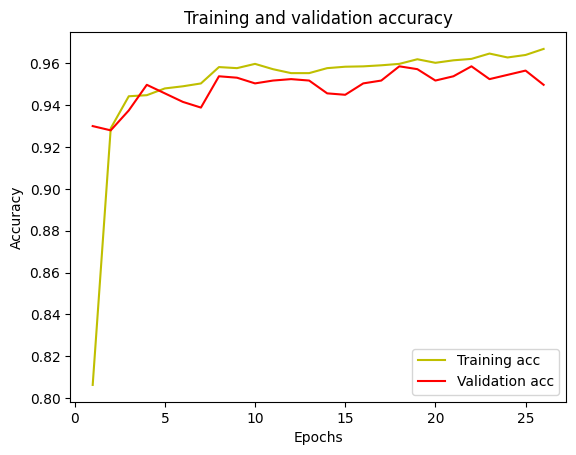

In [11]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step
[[486   0  10   0   0   0]
 [  1 468   1   1   0   0]
 [  0   2 418   0   0   0]
 [ 13   4   2 398  74   0]
 [  0   0   0 109 423   0]
 [  0   0   0   0   0 537]]
Accuracy: 0.9263657957244655

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       496
           1       0.99      0.99      0.99       471
           2       0.97      1.00      0.98       420
           3       0.78      0.81      0.80       491
           4       0.85      0.80      0.82       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



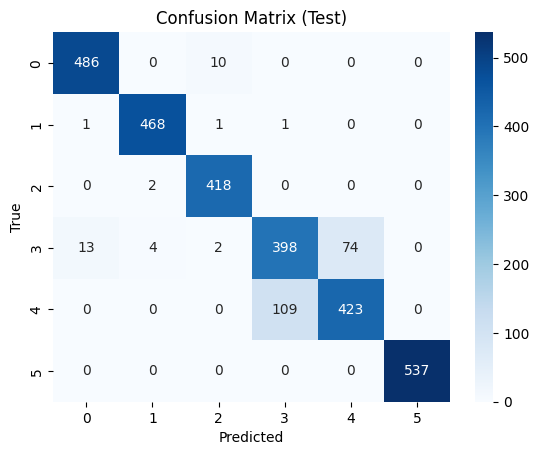

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


pred = model.predict(testX)
pred = np.argmax(pred, axis=-1)

y_true = testy.ravel()

# 혼동행렬, 정확도, 리포트
cm = confusion_matrix(y_true, pred)
print(cm)
print("Accuracy:", accuracy_score(y_true, pred))
print("\nClassification Report:")
print(classification_report(y_true, pred))

# 혼동행렬 시각화
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.show()
